<a href="https://colab.research.google.com/github/shabahmd/Machine-Learning-Notebooks/blob/main/titanic_spaceship.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style= 'darkgrid', font_scale=2)
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier # Fixed typo in class name: DecsionTreeClassifeir --> DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

In [61]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.8 MB/s eta 0:00:00


In [2]:
!mkdir ~/.kaggle

!mv kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c spaceship-titanic

!unzip spaceship-titanic


  0% 0.00/299k [00:00<?, ?B/s]
100% 299k/299k [00:00<00:00, 58.8MB/s]
Archive:  spaceship-titanic.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [7]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [9]:
train_df.shape

(8693, 14)

In [10]:
test_df.shape

(4277, 13)

In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


<Axes: xlabel='Transported', ylabel='count'>

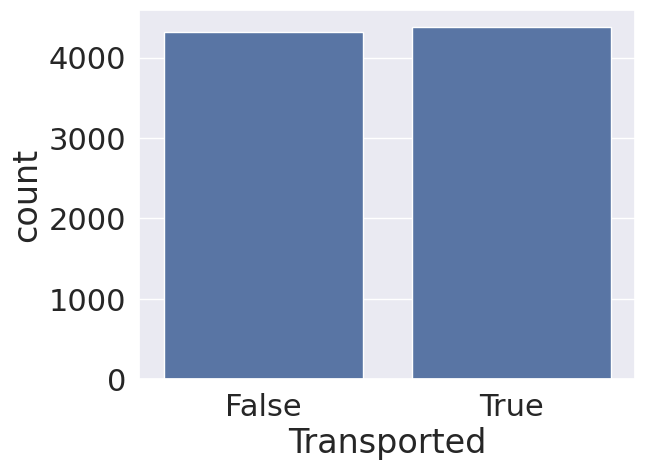

In [16]:
sns.countplot(x = 'Transported', data = train_df)

In [21]:
train_df['Transported'].value_counts()

,count
Transported,
True,4378
False,4315


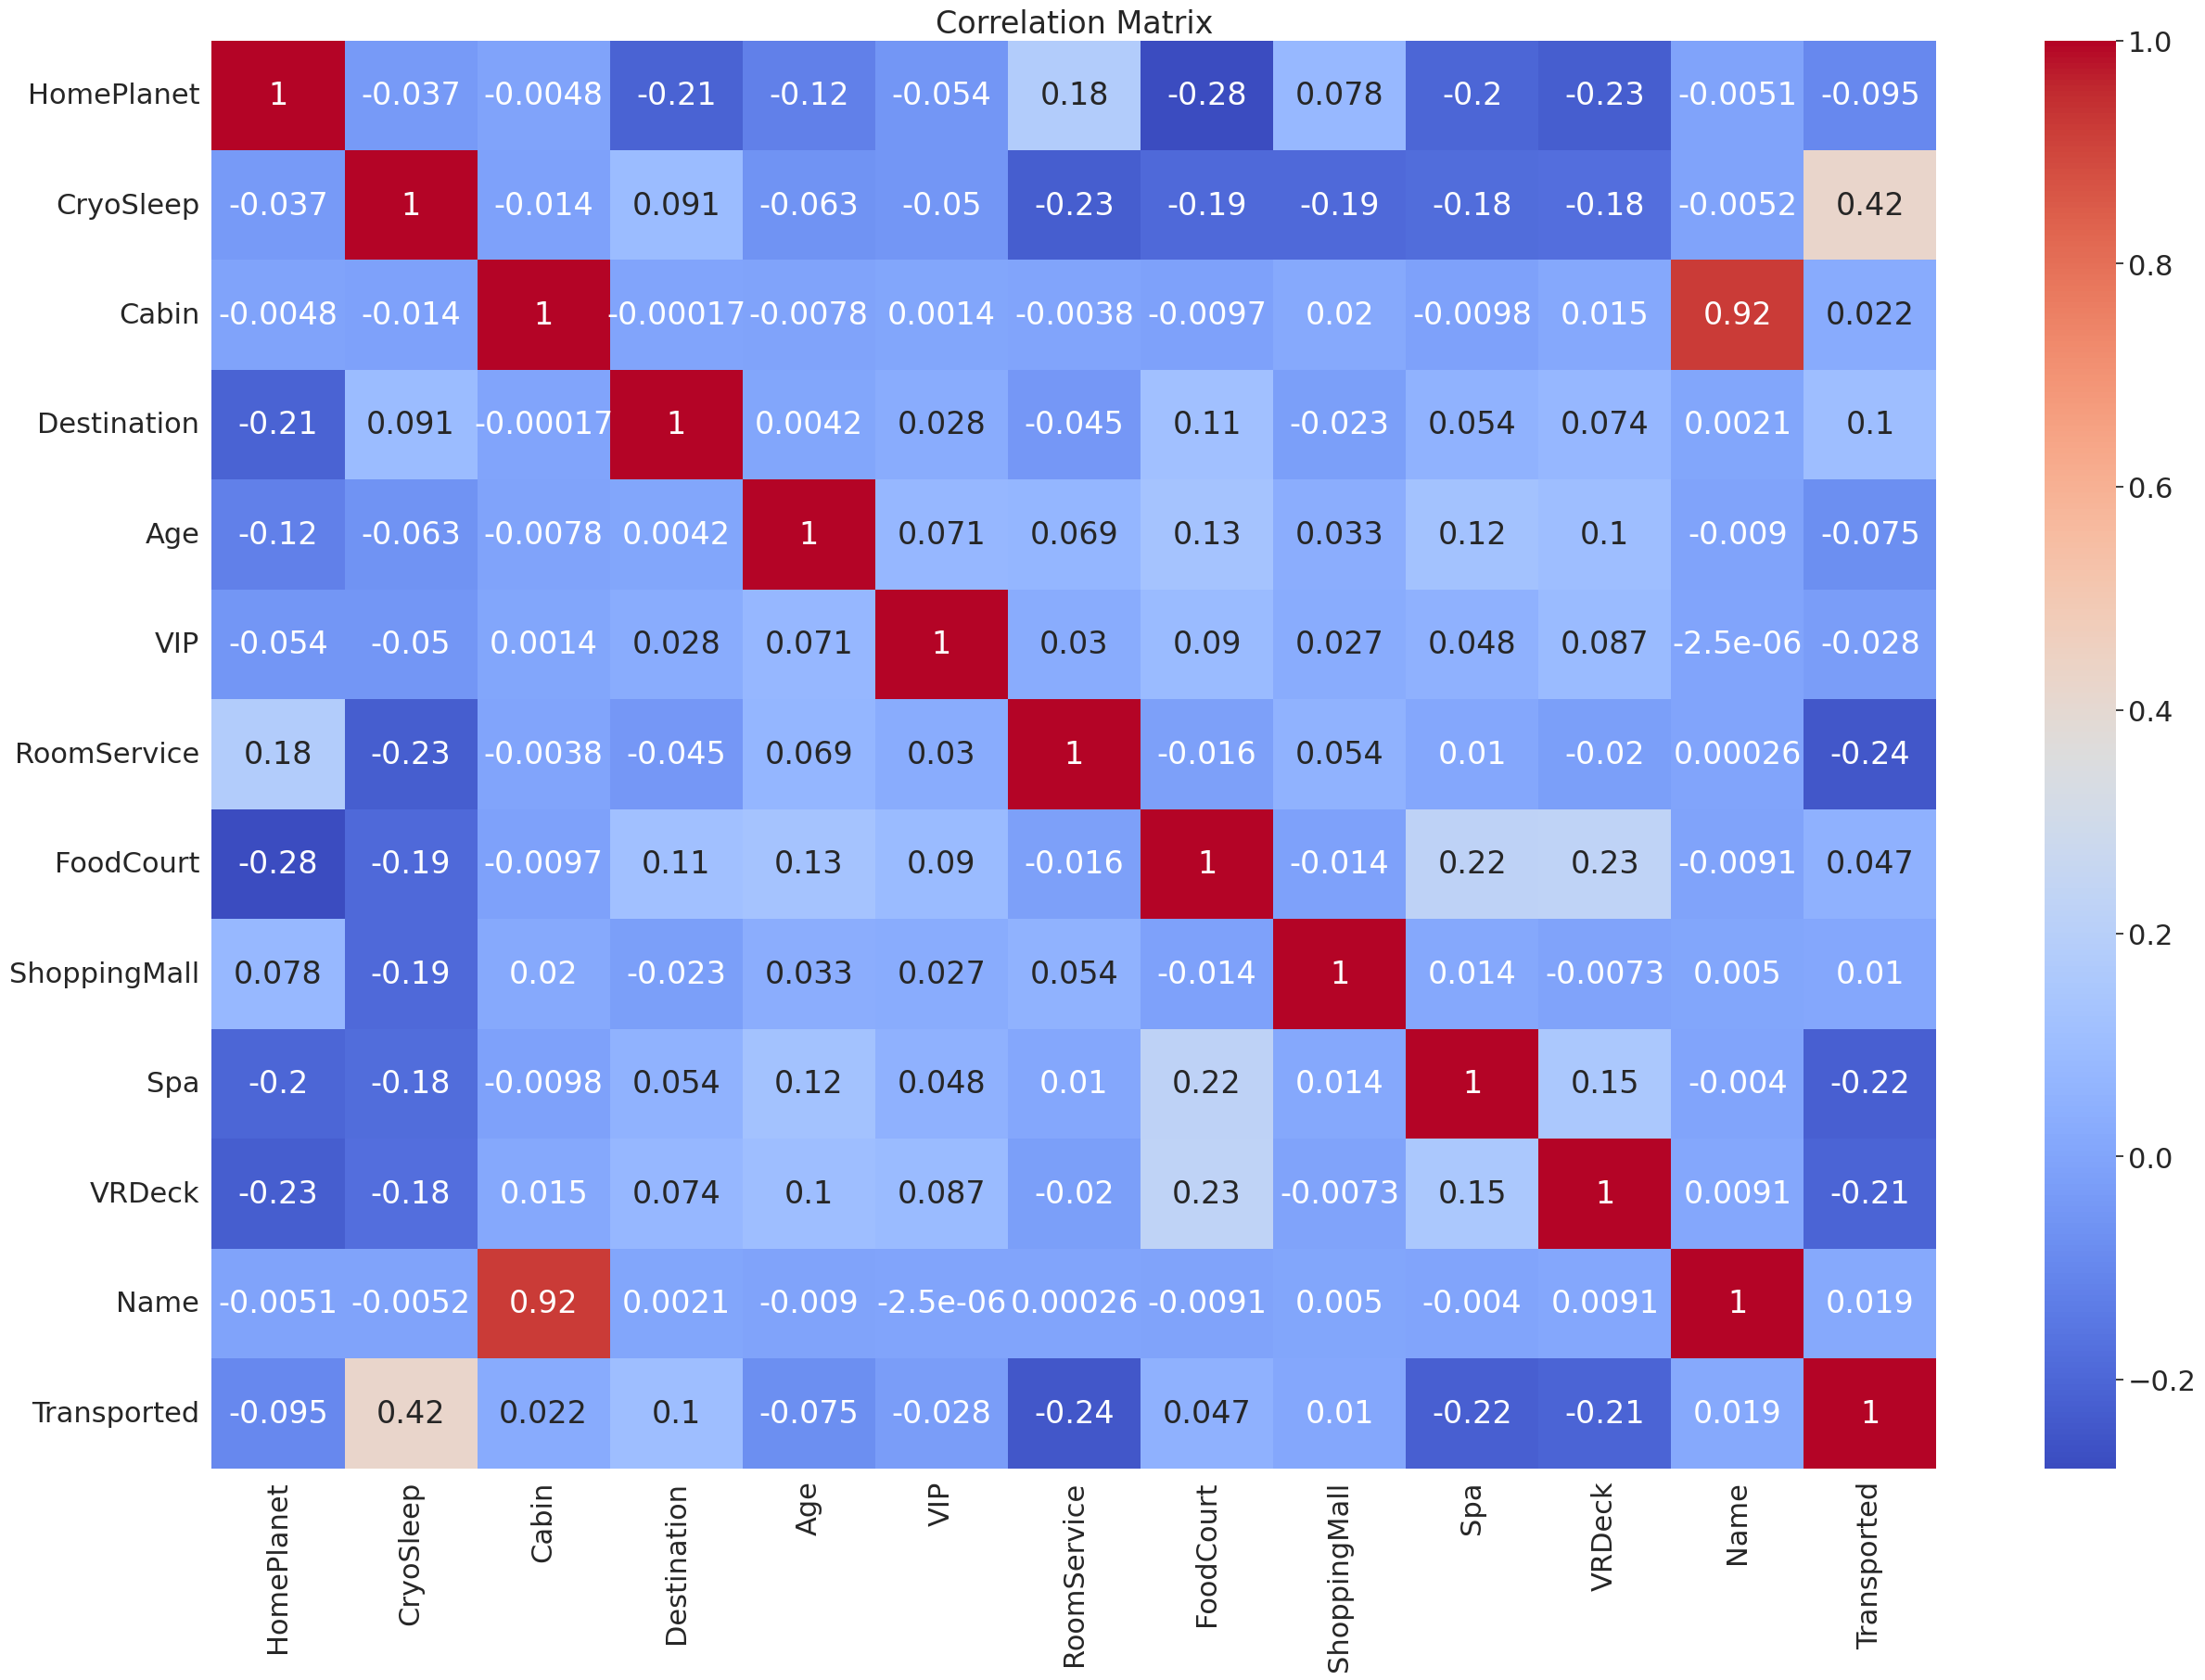

In [24]:
df_dropped = train_df.dropna()
df_dropped = train_df.drop('PassengerId', axis =1)
df_encoded = df_dropped.apply(lambda x: pd.factorize(x)[0] if x.dtype == 'object' else  x)

correlation_matrix = df_encoded.corr()

correlation_matrix
plt.figure(figsize =(30, 20))
sns.heatmap(correlation_matrix, annot= True, cmap= 'coolwarm')

plt.title('Correlation Matrix')
plt.show()


In [25]:
cate_col = train_df.select_dtypes(include=['object']).columns

# Find unique categories and their counts for each categorical column
unique_categories = {col: train_df[col].value_counts() for col in cate_col}

# Set the size of the overall figure
plt.figure(figsize=(15, len(cate_col) * 5))

# Plot the count of each unique category
for i, (col, counts) in enumerate(unique_categories.items(), 1):
    plt.subplot(len(cate_col), 1, i)
    sns.barplot(x=counts.index, y=counts.values, palette="viridis")
    plt.title(f"Count of unique categories in column '{col}'")
    plt.xlabel('Categories')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

plt.show()



<ipython-input-25-f28f2de1065b>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="viridis")
<ipython-input-25-f28f2de1065b>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="viridis")
<ipython-input-25-f28f2de1065b>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="viridis")
<ipython-input-25-f28f2de1065b>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assi

KeyboardInterrupt: 

# **Calculate Chi Score**

In [30]:
alpha = 0.05
import scipy

values = {}

for col in train_df.columns:
    if col == "transported":
        continue

    A, B = train_df[col], train_df["Transported"]

    dfObserved = pd.crosstab(A, B)
    chi2, p, dof, expected = scipy.stats.chi2_contingency(dfObserved.values)
    values[col] = p
    if p < alpha:
        # Reject null hypothesis
        print("{} is important. (p = {})".format(col, p))
    else:
        # Accept null hypothesis
        print("{} is NOT important. (p = {})".format(col, p))



PassengerId is NOT important. (p = 0.49495731665065185)
HomePlanet is important. (p = 2.809059985251311e-71)
CryoSleep is important. (p = 0.0)
Cabin is important. (p = 0.006047486175170891)
Destination is important. (p = 7.892901466137099e-24)
Age is important. (p = 5.156587040759446e-21)
VIP is important. (p = 0.0006804064556968345)
RoomService is important. (p = 5.257901500012457e-32)
FoodCourt is important. (p = 6.115977833465872e-22)
ShoppingMall is important. (p = 1.1255484486480233e-32)
Spa is important. (p = 8.183566403754326e-29)
VRDeck is important. (p = 8.325863105588776e-21)
Name is NOT important. (p = 0.48876786452724674)
Transported is important. (p = 0.0)


In [28]:
!pip install scipy


In [31]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [34]:
train_df = train_df.drop(['PassengerId', 'Name' ],axis =1)

In [36]:
numeric_feats = train_df.select_dtypes(include= ['float64']).columns.tolist()
for feat in numeric_feats:
  median_value = train_df[feat].mean()
  train_df[feat].fillna(median_value, inplace = True)

In [52]:
cat_feats = train_df.select_dtypes(include = ['object'])
print([cat_feats])

[     HomePlanet CryoSleep     Cabin    Destination    VIP
0        Europa     False     B/0/P    TRAPPIST-1e  False
1         Earth     False     F/0/S    TRAPPIST-1e  False
2        Europa     False     A/0/S    TRAPPIST-1e   True
3        Europa     False     A/0/S    TRAPPIST-1e  False
4         Earth     False     F/1/S    TRAPPIST-1e  False
...         ...       ...       ...            ...    ...
8688     Europa     False    A/98/P    55 Cancri e   True
8689      Earth      True  G/1499/S  PSO J318.5-22  False
8690      Earth     False  G/1500/S    TRAPPIST-1e  False
8691     Europa     False   E/608/S    55 Cancri e  False
8692     Europa     False   E/608/S    TRAPPIST-1e  False

[8693 rows x 5 columns]]


In [45]:
train_df.isnull().sum()

,0
HomePlanet,201
CryoSleep,217
Cabin,199
Destination,182
Age,0
VIP,203
RoomService,0
FoodCourt,0
ShoppingMall,0
Spa,0


In [42]:
col_dtypes

['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

## Calculate Percentage of Missing Values

In [47]:
def null_percent(df):
  per  = ((df.isnull().sum()/len(df))*100).round(4)
  return per

print(null_percent(train_df))


HomePlanet      2.3122
CryoSleep       2.4963
Cabin           2.2892
Destination     2.0936
Age             0.0000
VIP             2.3352
RoomService     0.0000
FoodCourt       0.0000
ShoppingMall    0.0000
Spa             0.0000
VRDeck          0.0000
Transported     0.0000
dtype: float64


In [48]:

def detect_outliers_iqr(data, column):
  Q1 = data[column].quantile(0.01)
  Q3 = data[column].quantile(0.99)
  IQR = Q3 - Q1
  lower_bound =  Q1 - 1.5 * IQR
  upper_bound =  Q3 + 1.5 * IQR
  return data[(data[column]< lower_bound) | (data[column]>upper_bound)]
for column in numeric_feats:
  outliers = detect_outliers_iqr(train_df, column)
  print(f'Number of outliers in {column}: {outliers.shape[0]}')


Number of outliers in Age: 0
Number of outliers in RoomService: 9
Number of outliers in FoodCourt: 5
Number of outliers in ShoppingMall: 14
Number of outliers in Spa: 10
Number of outliers in VRDeck: 6


In [50]:
def cap_outliers(data, column):
  Q1 = data[column].quantile(0.01)
  Q3 = data[column].quantile(0.99)
  IQR = Q3- Q1
  lower_bound = Q1 -1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  data[column]  = np.where(data[column]< lower_bound, lower_bound, data[column])
  data[column] = np.where(data[column] > upper_bound, upper_bound, data[column])

for column in numeric_feats:
  cap_outliers(train_df, column)


In [54]:
import pandas as pd

def cleaning(df):
    threshold = 100

    cat_feats = ["HomePlanet", "CryoSleep",     "Cabin" ,   "Destination"  ,  "VIP"]

    for feat in cat_feats:
        if df[feat].dtype.name == 'category':
            # Add 'missing' and 'noise' to categories if not present
            if 'missing' not in df[feat].cat.categories:
                df[feat] = df[feat].cat.add_categories('missing')
            if 'noise' not in df[feat].cat.categories:
                df[feat] = df[feat].cat.add_categories('noise')
        else:
            # Convert to category and add new categories
            df[feat] = df[feat].astype('category')
            df[feat] = df[feat].cat.add_categories(['missing', 'noise'])

        # Fill missing values with 'missing'
        df[feat] = df[feat].fillna('missing')

        # Replace infrequent categories with 'noise'
        counts = df[feat].value_counts(dropna=False)
        infrequent_categories = counts[counts < threshold].index
        df[feat] = df[feat].apply(lambda x: 'noise' if x in infrequent_categories else x)

    return df

# Example usage
train_data = cleaning(train_df)


In [55]:
train_df.head()


,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,Europa,False,noise,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False
1,Earth,False,noise,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True
2,Europa,False,noise,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False
3,Europa,False,noise,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False
4,Earth,False,noise,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True


In [56]:
print(null_percent(train_data))


HomePlanet      0.0
CryoSleep       0.0
Cabin           0.0
Destination     0.0
Age             0.0
VIP             0.0
RoomService     0.0
FoodCourt       0.0
ShoppingMall    0.0
Spa             0.0
VRDeck          0.0
Transported     0.0
dtype: float64


In [57]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   HomePlanet    8693 non-null   category
 1   CryoSleep     8693 non-null   category
 2   Cabin         8693 non-null   object  
 3   Destination   8693 non-null   category
 4   Age           8693 non-null   float64 
 5   VIP           8693 non-null   category
 6   RoomService   8693 non-null   float64 
 7   FoodCourt     8693 non-null   float64 
 8   ShoppingMall  8693 non-null   float64 
 9   Spa           8693 non-null   float64 
 10  VRDeck        8693 non-null   float64 
 11  Transported   8693 non-null   bool    
dtypes: bool(1), category(4), float64(6), object(1)
memory usage: 518.8+ KB


In [58]:
X = train_df.drop(['Transported'], axis =1)
y = train_df['Transported']
X.shape, y.shape


((8693, 11), (8693,))

In [59]:
le = LabelEncoder()
y = le.fit_transform(y)

In [68]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import optuna

# Handle categorical columns by converting them to 'category' dtype
categorical_columns = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']  # List your categorical columns

for col in categorical_columns:
    train_df[col] = train_df[col].astype('category')

# Convert object columns (like 'Cabin') to numeric or category as needed
train_df['Cabin'] = train_df['Cabin'].astype('category')  # For 'Cabin', assume it should be categorical

# Define features and target
X = train_df.drop(['Transported'], axis=1)  # Features
y = train_df['Transported']  # Target

# Split the data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the objective function for Optuna
def objective(trial):
    param = {
        'verbosity': 0,
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'tree_method': 'hist',
        'booster': 'gbtree',
        'use_label_encoder': False,
        'enable_categorical': True,  # Enable categorical handling in XGBoost
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 3000),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0)
    }

    # Train the model
    model = xgb.XGBClassifier(**param)
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)

    preds = model.predict(X_valid)

    # Calculate accuracy and MCC
    accuracy = accuracy_score(y_valid, preds)
    mcc = matthews_corrcoef(y_valid, preds)

    return mcc  # Maximizing MCC

# Optimize hyperparameters with Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Get the best parameters
best_params = study.best_params
print("Best hyperparameters: ", best_params)

# Train the final model
best_model = xgb.XGBClassifier(**best_params, enable_categorical=True)
best_model.fit(X_train, y_train)

# Predictions and final evaluation
y_pred = best_model.predict(X_valid)
final_accuracy = accuracy_score(y_valid, y_pred)
final_mcc = matthews_corrcoef(y_valid, y_pred)

print(f"Final Accuracy: {final_accuracy}")
print(f"Final MCC: {final_mcc}")


[I 2024-09-08 14:44:53,233] A new study created in memory with name: no-name-1f55d123-ad0b-47be-b077-0836692d4087
<ipython-input-68-04f711d09023>:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
<ipython-input-68-04f711d09023>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
<ipython-input-68-04f711d09023>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0

Best hyperparameters:  {'lambda': 0.04697090397863635, 'alpha': 4.105238841067864e-06, 'colsample_bytree': 0.9406246592543973, 'subsample': 0.6050060205867719, 'learning_rate': 0.015662704940657614, 'n_estimators': 105, 'max_depth': 9, 'min_child_weight': 7, 'gamma': 3.838778466682634e-06}
Final Accuracy: 0.7912593444508338
Final MCC: 0.5836324945987212
